<a href="https://colab.research.google.com/github/jofmorenore/Spatial_Clustering/blob/main/Spatial_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [Grubesic, T, R. Wei and A. Murray (2014). Spatial clustering overview and comparison: accuracy, sensitivity and computational expense. Annals, Association of American Geographers 104, 1134-1156.](https://doi.org/10.1080/00045608.2014.958389)


# Configuración del entorno R en colab

In [1]:
# https://stackoverflow.com/questions/74283327/conversion-py2rpy-not-defined-for-objects-of-type-class-str
!pip install rpy2==3.5.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
%load_ext rpy2.ipython

In [3]:
%%R
getwd()

[1] "/content"


In [4]:
%%R
sessionInfo()

R version 4.2.3 (2023-03-15)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 20.04.5 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas-pthread/libblas.so.3
LAPACK: /usr/lib/x86_64-linux-gnu/openblas-pthread/liblapack.so.3

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] tools     stats     graphics  grDevices utils     datasets  methods  
[8] base     

loaded via a namespace (and not attached):
[1] compiler_4.2.3


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# [Tipos de datos espaciales](http://user.math.uzh.ch/furrer/download/useR/20210707Furrer.pdf)

<p><img height="767" src="https://github.com/jofmorenore/Spatial_Clustering/raw/main/images/spatial_statistics.png" width="1057"/>

# [Datos de asaltos en Cincinnati](https://github.com/spatialanalysis/geodaData/blob/master/R/cincinnati.R)

In [6]:
%%R
library(dplyr)
library(ggplot2)
library(stringr)

Attaching package: ‘dplyr’



    filter, lag



    intersect, setdiff, setequal, union




In [7]:
%%R
if("sf" %in% row.names(installed.packages())==FALSE){suppressMessages(install.packages("sf"))}
library(sf)

In [8]:
%%R
load('/content/drive/MyDrive/cincinnati.rda')
str(cincinnati, max.level = 1)

Classes ‘sf’ and 'data.frame':	457 obs. of  73 variables:
 $ ID        : num  726907 695744 695762 695780 695798 ...
 $ AREA      : num  0.09 0.01 0.01 0.01 0.02 0.01 0 0 0 0.01 ...
 $ BLOCK     : chr  "390610042002001" "390610022004003" "390610033002017" "390610022004002" ...
 $ BG        : chr  "390610042002" "390610022004" "390610033002" "390610022004" ...
 $ TRACT     : chr  "39061004200" "39061002200" "39061003300" "39061002200" ...
 $ COUNTY    : chr  "39061" "39061" "39061" "39061" ...
 $ MSA       : chr  "1640" "1640" "1640" "1640" ...
 $ POPULATION: num  479 85 29 117 96 45 81 32 41 89 ...
 $ MALE      : num  221 39 18 59 51 30 39 21 27 33 ...
 $ FEMALE    : num  258 46 11 58 45 15 42 11 14 56 ...
 $ AGE_0_5   : num  6 5 0 9 1 0 3 1 0 5 ...
 $ AGE_5_9   : num  6 4 0 10 2 3 5 0 0 2 ...
 $ AGE_10_14 : num  3 8 0 11 2 1 9 0 0 7 ...
 $ AGE_15_19 : num  9 12 0 17 5 2 14 2 7 12 ...
 $ AGE_20_24 : num  32 6 13 12 28 14 29 19 11 26 ...
 $ AGE_25_34 : num  60 13 6 19 44 11 8 4 9 12 ...

In [9]:
%%R
n_blocks = n_distinct(cincinnati$ID)
n_assaults = sum(cincinnati$ASSAULT)
n_population = sum(cincinnati$POPULATION)
assault_rate = round((n_assaults/n_population)*100000)

cat("There are",n_blocks,"census blocks in the study area and the total number of observed assaults was",
    n_assaults,"for the time period examined. \nIn early 2008, the study area had a population of approximately",
    n_population,"over 148.7 km 2 (10.6 percent and 6.3 percent of the city, respectively). \nThe assault rate of this region is",
    assault_rate, "per 100,000 people, nearly 1.6 times the rate of the city with a relative risk of assault ranging from 0 to 45.2")


There are 457 census blocks in the study area and the total number of observed assaults was 462 for the time period examined. 
In early 2008, the study area had a population of approximately 38711 over 148.7 km 2 (10.6 percent and 6.3 percent of the city, respectively). 
The assault rate of this region is 1193 per 100,000 people, nearly 1.6 times the rate of the city with a relative risk of assault ranging from 0 to 45.2

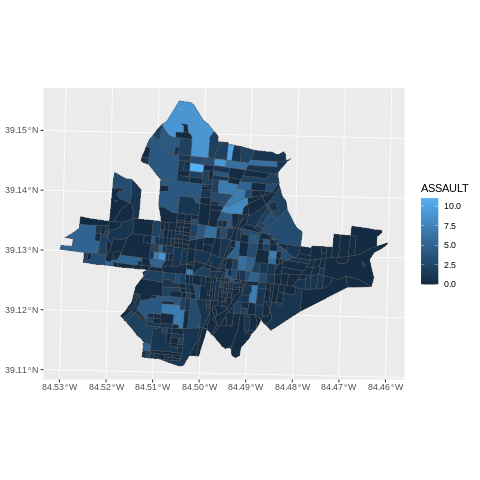

In [10]:
%%R
ggplot() + 
  geom_sf(data = cincinnati, aes(fill = `ASSAULT`))

# Basados en Escaneo

## [Flex Scan](https://cran.r-project.org/web/packages/FlexScan/FlexScan.pdf)

In [11]:
%%R
if("FlexScan" %in% row.names(installed.packages())==FALSE){suppressMessages(install.packages("FlexScan"))}
library(FlexScan)

In [12]:
%%R
FS = flexscan(sf:::as_Spatial(cincinnati$geometry),
              case=cincinnati$ASSAULT,    # case numeric, a vector of number of cases for each region of ’map’
              pop=cincinnati$POPULATION,  # pop numeric, a vector of number of population for each region of ’map’
              k=10,                       # k numeric, the maximum number of regions allowed for clusters; the default is 10
              alpha=0.05,               # numeric, the significance level of flexible scan test; the default is 0.05
              isplot=FALSE,               # isplot logical, wether to plot the results; the default is 0.05
              nsim=999                    # nsim numeric, the number of simulations for Monte Carlo test; the default is 999
              )

  |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=03m 18s


In [13]:
%%R
FS_df = as.data.frame(FS) %>% mutate_at(vars(names(.)[3:ncol(FS)]), as.numeric) %>%
          filter(`Expected Cases`>0) %>% filter(LLR == max(LLR)) %>%
          mutate("Selected Units" = length(str_split(`Region ID`, ",")[[1]])) %>%
          select(c(`Region ID`, "Cases"= `Observed Cases`, `Selected Units`,  `Expected Cases`, `LLR`, `P Value`))

FS_regions = as.numeric(str_split(FS_df$`Region ID`, ",")[[1]])
FS_clust = cincinnati[FS_regions,]

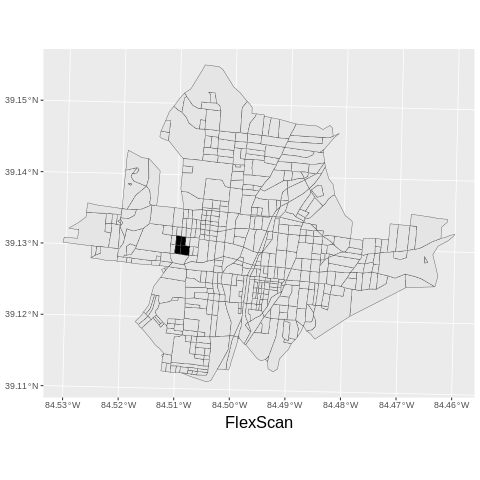

In [14]:
%%R
ggplot() + 
  geom_sf(data = cincinnati) +
  geom_sf(data = FS_clust, aes(fill = as.factor(ASSALT_D))) +
  scale_fill_manual(values = c("black",""))+ 
  theme(legend.position="none")+
  labs(caption = "FlexScan") + 
  theme(plot.caption = element_text(hjust=0.5, size=rel(1.5)))

## [Kulldorff's Scan](https://cran.r-project.org/web/packages/SpatialEpi/SpatialEpi.pdf)

In [15]:
%%R
if("SpatialEpi" %in% row.names(installed.packages())==FALSE){suppressMessages(install.packages("SpatialEpi"))}
library(SpatialEpi)

In [16]:
%%R
## Kulldorff using Poisson likelihoods
geo = cincinnati %>% group_by(ID) %>% summarise(st_centroid(geometry)) %>% st_coordinates() %>% as.data.frame()
EC = SpatialEpi::expected(cincinnati$POPULATION, cincinnati$ASSAULT, 1)

### [Error in kulldorff function for cincinnati data](https://github.com/rudeboybert/SpatialEpi/issues/38)

In [17]:
%%R
geo = cincinnati %>% group_by(ID) %>% summarise(st_centroid(geometry)) %>% st_coordinates() %>% as.data.frame()
EC = SpatialEpi::expected(cincinnati$POPULATION, cincinnati$ASSAULT, 1)

poisson <- kulldorff(geo,                     # an n x 2 table of the (x,y)-coordinates of the area centroids
                     cincinnati$ASSAULT,      # aggregated case counts for all n areas
                     cincinnati$POPULATION,   # aggregated population counts for all n areas
                     expected.cases=EC,       # expected numbers of disease for all n areas 
                     pop.upper.bound=0.5,     # the upper bound on the proportion of the total population each zone can include
                     n.simulations=999,       # number of Monte Carlo samples used for significance measures
                     alpha.level=0.05,        # alpha-level threshold used to declare significance
                     plot=TRUE                # flag for whether to plot histogram of Monte Carlo samples of the LL of the most likely cluster
                     )

  invalid number of 'breaks'




Error in hist.default(combined.lambda, main = "Monte Carlo Distribution of Lambda",  : 
  invalid number of 'breaks'


RInterpreterError: ignored

### Ejemplo de la librería

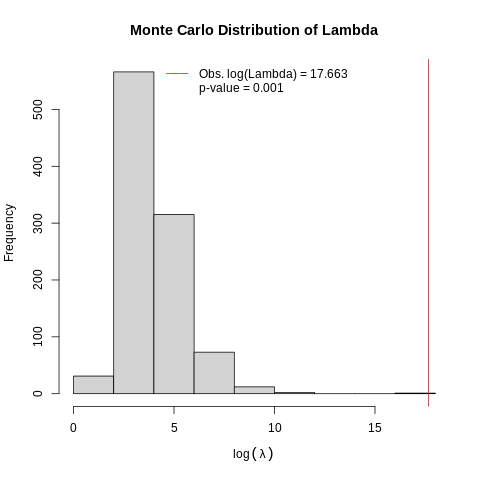

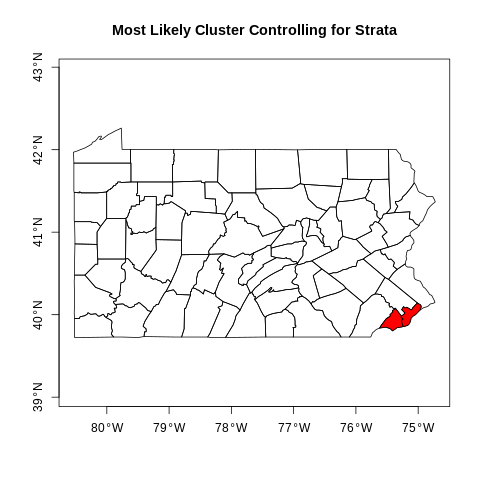

In [18]:
%%R
data(pennLC, package = "SpatialEpi")
data <- pennLC$data

## Process geographical information and convert to grid
geo <- pennLC$geo[,2:3]
geo <- latlong2grid(geo)

## Get aggregated counts of population and cases for each county
population <- tapply(data$population,data$county,sum)
cases <- tapply(data$cases,data$county,sum)

## Based on the 16 strata levels, computed expected numbers of disease
n.strata <- 16
expected.cases <- expected(data$population, data$cases, n.strata)

## Set Parameters
pop.upper.bound <- 0.5
n.simulations <- 999
alpha.level <- 0.05
plot <- TRUE

## Kulldorff using Poisson likelihoods
poisson <- kulldorff(geo, cases, population, expected.cases, pop.upper.bound,
n.simulations, alpha.level, plot)
cluster <- poisson$most.likely.cluster$location.IDs.included

## plot
plot(pennLC$spatial.polygon,axes=TRUE)
plot(pennLC$spatial.polygon[cluster],add=TRUE,col="red")
title("Most Likely Cluster Controlling for Strata")

## [GAScan](https://doi.org/10.1080/13658816.2010.533674)

## [Contiguous-Max-LLR model](https://doi.org/10.1016/j.spasta.2014.03.001)